Loading the Data

In [31]:
import torch
import torchaudio
import os
from torchaudio.datasets import SPEECHCOMMANDS
class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)
        
        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

print(f"Shape of waveform: {waveform.size()}")
print(f"Label: {label}")
print(f"Sample Rate: {sample_rate}")

Shape of waveform: torch.Size([1, 16000])
Label: backward
Sample Rate: 16000


For the recognition, we will try to just recognize what a word looks like using a convolutional neural network. So we can transform the audio from raw audio into a 2d spectogram then input that into the cnn. Additionally, for shorter words, the cnn can find the word shape wherever it is in the word.

In [82]:
transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_mels=64
)
spectrogram = transform(waveform)
print("Shape: ", spectrogram.shape)

Shape:  torch.Size([1, 64, 81])


Showing what a spectogram looks like

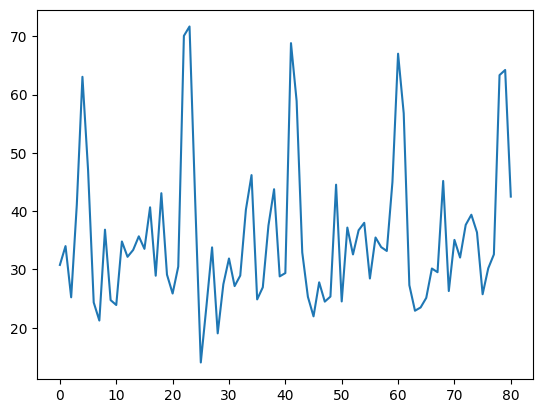

In [87]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(spectrogram[0][0])

Making labels for training. ready_data function is used to standardize the data and 

In [86]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
label_to_index = {label: index for index, label in enumerate(labels)}
def ready_data(batch):
    #A batch is a list of objects in the train set
    tensors, targets = [],[]
    for waveform, _, label, *_ in batch:
        tensors += [waveform.squeeze(0)]
        targets += [label_to_index[label]]
    # makes all samples the same size
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)

    #makes targets into single tensor
    targets = torch.stack([torch.tensor(t) for t in targets])
    return tensors, targets
    

In [99]:
num_labels = len(set(labels))
print(labels)
print(train_set[4][2])
print(num_labels)
print()

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
backward
35



Using the cnn we used for homework

In [89]:
from torchvision import models
import torch.nn as nn

In [90]:
model = models.mobilenet_v2(pretrained=True)

/Users/bolajialabi/Projects/MLenv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bolajialabi/Projects/MLenv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

Im training using my mac so this is for using mac gpus.

In [91]:
import torch.optim as optim
from tqdm import tqdm
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device found. Using MPS.")
else:
    device = torch.device("cpu")
    print("MPS not available. Using CPU.")

MPS device found. Using MPS.


training preperation

In [92]:
num_features = model.features[-1].out_channels
print(num_features)

1280


In [93]:
train_loader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=32, 
    shuffle=True, 
    collate_fn=ready_data,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=32, 
    shuffle=False, 
    collate_fn=ready_data,
    num_workers=0
)

num_hidden = 100


model.classifier = nn.Sequential(
nn.Dropout(0.2),
nn.Linear(in_features=num_features, out_features=num_hidden),
nn.ReLU(),
nn.Linear(in_features=num_hidden, out_features=num_labels)
)
# Making process run on gpu
model = model.to(device)

transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=64).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Train step

In [96]:
nepochs = 5
for epoch in range(nepochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)
    for images, targets in loop:
        images = images.to(device)
        targets = targets.to(device)

        #making image 3d to match rgb
        spectrogram = transform(images)
        spectrogram = spectrogram.unsqueeze(1)
        spectrogram = spectrogram.repeat(1,3,1,1)

        optimizer.zero_grad()
        outputs = model(spectrogram)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {running_loss:.4f}")

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        loop = tqdm(test_loader, desc="Evaluating", leave=True)
        for images, targets in loop:

            images = images.to(device)
            targets = targets.to(device)
            spectrogram = transform(images)
            spectrogram = spectrogram.unsqueeze(1)
            spectrogram = spectrogram.repeat(1,3,1,1)
            outputs = model(spectrogram)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            accuracy = 100 * correct / total 
            loop.set_postfix({'Accuracy': f'{accuracy:.2f}%'})
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Test Accuracy: {accuracy:.2f}%\n")


Epoch 1: 100%|██████████| 2652/2652 [06:38<00:00,  6.65it/s, loss=0.787]


Epoch 1, Training Loss: 2871.2212


Evaluating: 100%|██████████| 344/344 [00:38<00:00,  8.98it/s, Accuracy=80.46%]


Epoch 1, Test Accuracy: 80.46%



Epoch 2: 100%|██████████| 2652/2652 [06:42<00:00,  6.59it/s, loss=0.406] 


Epoch 2, Training Loss: 1319.7003


Evaluating: 100%|██████████| 344/344 [00:37<00:00,  9.12it/s, Accuracy=70.89%]


Epoch 2, Test Accuracy: 70.89%



Epoch 3: 100%|██████████| 2652/2652 [06:30<00:00,  6.79it/s, loss=0.393] 


Epoch 3, Training Loss: 995.1158


Evaluating: 100%|██████████| 344/344 [00:35<00:00,  9.80it/s, Accuracy=75.61%]


Epoch 3, Test Accuracy: 75.61%



Epoch 4: 100%|██████████| 2652/2652 [06:27<00:00,  6.85it/s, loss=0.154] 


Epoch 4, Training Loss: 810.4070


Evaluating: 100%|██████████| 344/344 [00:36<00:00,  9.48it/s, Accuracy=76.56%]


Epoch 4, Test Accuracy: 76.56%



Epoch 5: 100%|██████████| 2652/2652 [06:19<00:00,  6.99it/s, loss=0.617] 


Epoch 5, Training Loss: 688.1902


Evaluating: 100%|██████████| 344/344 [00:35<00:00,  9.56it/s, Accuracy=76.29%]

Epoch 5, Test Accuracy: 76.29%



In [100]:
import torch
import torchaudio

def predict_single_file(filepath, model, transform, class_names, device):
    waveform, sample_rate = torchaudio.load(filepath)
    
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform).to(device)

    spectrogram = transform(waveform)
    spectrogram = spectrogram.unsqueeze(0) 

    # 4. Move to device
    spectrogram = spectrogram.to(device)
    spectrogram = spectrogram.repeat(1,3,1,1)

    # 5. Predict
    model.eval() # Switch to eval mode (turns off dropout, etc.)
    with torch.no_grad():
        output = model(spectrogram)
        
        # Get the class with the highest score
        prediction_index = output.argmax(dim=1).item()
        predicted_label = class_names[prediction_index]
        confidence = output.softmax(dim=1).max().item()

    return predicted_label, confidence

In [101]:
wav_file_path = "batHappy.wav" # Replace this with your file path

prediction, conf = predict_single_file(
    wav_file_path, 
    model, 
    transform, 
    labels, 
    device
)

print(f"Prediction: {prediction}")
print(f"Confidence: {conf * 100:.2f}%")
print(label_to_index["happy"])

Prediction: happy
Confidence: 100.00%
12


Next, I will try a 1D CNN that is better accustomed for this task.

In [20]:
#same as ready data command but for 1D data
def ready_data_array(batch):
    batch = [item for item in batch]
    tensors = [item[0].permute(1,0) for item in batch]
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first=True)
    tensors = tensors.permute(0, 2, 1)

    targets = torch.tensor([label_to_index[item[2]] for item in batch])

    return tensors, targets

In [78]:
# New Data Loader
batch_size = 256

train_loader2 = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, collate_fn=ready_data_array, num_workers=0
)

test_loader2 = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, collate_fn=ready_data_array, num_workers=0
)

I will be using the M5 model for this. It appears that M5 is known for processing raw audio.

In [34]:
import torch.nn.functional as F

class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)

        # Block 2
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)

        # Block 3
        self.conv3 = nn.Conv1d(n_channel, 2 *n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2*n_channel)
        self.pool3 = nn.MaxPool1d(4)

        #Block 4
        self.conv4 = nn.Conv1d(2*n_channel, 2 *n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2*n_channel)
        self.pool4 = nn.MaxPool1d(4)
        
        #Output Layer
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0,2,1)
        x = self.fc1(x)

        return F.log_softmax(x, dim=2)

In [35]:
# Model declaration
model2 = M5(n_input=1, n_output=len(labels))
model2.to(device)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=29, bias=True)
)

In [ ]:
# training


optimizer2 = optim.Adam(model2.parameters(), lr=0.001, weight_decay=0.0001)
scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=20, gamma= 0.1)

log_i = 20

for epoch in range(1, nepochs+ 1):
    model2.train()
    running_loss = 0.0
    loop = tqdm(train_loader2, desc=f"Epoch {epoch}", leave=True)
    for sound, target in loop:
        sound = sound.to(device)
        target = target.to(device)

        optimizer2.zero_grad()
        output = model2(sound)

        output = output.squeeze()
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer2.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    print(f"Epoch {epoch}, Training Loss: {running_loss:.4f}")

    model2.eval()
    correct = 0

    with torch.no_grad():
        loop = tqdm(test_loader2, desc="Evaluating", leave=True)
        for sound, target in loop:
            sound = sound.to(device)
            target = target.to(device)
            output = model2(sound)
            output = output.squeeze()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    acc = 100. * correct / len(test_loader.dataset)
    print(f"Epoch {epoch}, Test Accuracy: {acc:.2f}%\n")
    scheduler2.step()

Epoch 1: 100%|██████████| 332/332 [04:19<00:00,  1.28it/s, loss=0.0774]


Epoch 1, Training Loss: 75.6278


Evaluating: 100%|██████████| 43/43 [00:30<00:00,  1.41it/s]


Epoch 2, Test Accuracy: 72.89%



Epoch 2: 100%|██████████| 332/332 [04:03<00:00,  1.36it/s, loss=0.451]


Epoch 2, Training Loss: 72.7673


Evaluating: 100%|██████████| 43/43 [00:29<00:00,  1.46it/s]


Epoch 3, Test Accuracy: 73.03%



Epoch 3: 100%|██████████| 332/332 [04:06<00:00,  1.35it/s, loss=0.183]


Epoch 3, Training Loss: 70.8363


Evaluating: 100%|██████████| 43/43 [00:30<00:00,  1.43it/s]


Epoch 4, Test Accuracy: 72.80%



Epoch 4: 100%|██████████| 332/332 [04:14<00:00,  1.30it/s, loss=0.0968]


Epoch 4, Training Loss: 69.4152


Evaluating: 100%|██████████| 43/43 [00:31<00:00,  1.35it/s]


Epoch 5, Test Accuracy: 73.15%



Epoch 5: 100%|██████████| 332/332 [04:12<00:00,  1.31it/s, loss=0.266]


Epoch 5, Training Loss: 67.7568


Evaluating: 100%|██████████| 43/43 [00:32<00:00,  1.32it/s]

Epoch 6, Test Accuracy: 72.98%



In [103]:
def predict_single_file2(model, file_path, labels, device):
    model.eval()

    waveform, sample_rate= torchaudio.load(file_path)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform).to(device)
    
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    if waveform.shape[1] < 16000:
        # Pad with zeros
        padding = 16000 - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))
    elif waveform.shape[1] > 16000:
        waveform = waveform[:, :16000]
    
    input_tensor = waveform.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        output = output.squeeze()

        probability = torch.exp(output)
        top_p, top_class = probability.topk(1, dim=0)
    prediction = labels[top_class.item()]
    confidence = top_p.item()
    return prediction, confidence

In [104]:
wav_file_path = "batHappy.wav"

prediction, conf = predict_single_file2(model2, wav_file_path, labels, device)

print(f"Prediction: {prediction}")
print(f"Confidence: {conf*100:.2f}%")
print(f"Correct class: {label_to_index["happy"]}")

Prediction: happy
Confidence: 100.00%
Correct class: 12


Finally I will try to use an RNN for this task

In [105]:
BATCH_SIZE = 64
LR = 0.001

# Using Mel-Frequency Cepstral Coefficients to generate features that will be engineered using RNN
mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=40  # 40 features per time step
).to(device)

def ready_data3(batch):
    tensors, targets = [], []

    for waveform, _, label, _, _ in batch:
        target = label_to_index[label]
        
        if waveform.shape[1] < 16000:
            pad_amount = 16000 - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
        else:
            waveform = waveform[:, :16000]
        
        tensors.append(waveform)
        target.append(label)

    tensors = torch.stack(tensors).to(device)
    targets = torch.tensor(targets).to(device)

    mfcc = mfcc_transform(tensors).squeeze(1)

    mfcc = mfcc.transpose(1,2)

    return mfcc, targets

/Users/bolajialabi/Projects/MLenv/lib/python3.13/site-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [114]:
# Data loading again
train_loader3 = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, collate_fn=ready_data3, num_workers=0
)

test_loader3 = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, collate_fn=ready_data3, num_workers=0
)

Using Long Short Term Memory (LSTM) as recurrent neural network.

In [110]:
# Model Creation
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers=2):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = layers

        #LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, layers, batch_first=True, dropout=0.3)

        # Fully Connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layers, x.size(0), self.hidden_dim).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]

        out = self.fc(out)
        return out

In [111]:
# model initiation
model3 = LSTM(input_dim=40, hidden_dim=128, output_dim=len(labels)).to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=LR)
criterion3 = nn.CrossEntropyLoss()

In [ ]:
# Training ... again
for epoch in range(nepochs):
    model3.train()
    running_loss = 0.0
    correct = 0
    count = 0
    loop = tqdm(train_loader3, desc=f"Epoch {epoch}", leave=True)
    for data, target in loop:
        optimizer3.zero_grad()
        output = model3(data)
        
        loss = criterion3(output, target)
        loss.backward()
        optimizer3.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    print(f"Epoch {epoch}, Training Loss: {running_loss:.4f}")
    model3.eval()

    with torch.no_grad():
        loop = tqdm(test_loader3, desc="Evaluating", leave=True)
        for data, target in loop:
            data = data.to(device)
            target = target.to(device)
            output = model3(data)
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            count += len(data)
        acc = 100. * correct / count
        print(f"Epoch {epoch}, Test Accuracy: {acc:.2f}%\n")

Epoch 0:   0%|          | 0/332 [00:00<?, ?it/s]


AttributeError: 'int' object has no attribute 'append'